In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

target = 'Reduction of Area (%)'
trgt= 'Reduction_of_area'

# Charger les données
df = pd.read_csv(f'Transformed data/pca_transformed_dataset_{trgt}.csv')

# Séparer les features et la target
X = df.drop(columns=[target])
y = df[target]

# Séparer en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [2]:
import os

# Define the folder where the models are stored
model_folder = 'Trained model'  

# List all the saved models in the folder
model_files = [f for f in os.listdir(model_folder)]

# Initialize dictionary to store test results
results_test = {
    'Model': [],
    'Test MSE': [],
    'Test RMSE': [],
    'Test MAE': [],
    'Test R²': []
}

# Loop through the model files
for model_file in model_files:
    # Load the model
    model = joblib.load(os.path.join(model_folder, model_file))
    
    # Get the model name (by stripping the file extension)
    model_name = model_file.replace('_best_model.pkl', '')
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse_val = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results_test['Model'].append(model_name)
    results_test['Test MSE'].append(mse)
    results_test['Test RMSE'].append(rmse_val)
    results_test['Test MAE'].append(mae)
    results_test['Test R²'].append(r2)

# Convert the results to a DataFrame for easy viewing
results_test_df = pd.DataFrame(results_test)

# Display the results
results_test_df.sort_values('Test R²', ascending=False)



,Model,Test MSE,Test RMSE,Test MAE,Test R²
2,GradientBoostingRegressor,19.574926,4.424356,2.592554,0.738940
5,RandomForestRegressor,20.265520,4.501724,2.693547,0.729730
7,SVR,23.007675,4.796632,2.600143,0.693159
1,ElasticNetRegression,24.852051,4.985183,3.225065,0.668562
3,LassoRegression,25.166176,5.016590,3.268240,0.664372
6,RidgeRegression,25.524737,5.052201,3.317686,0.659590
4,LinearRegression,25.857600,5.085037,3.345870,0.655151
0,DecisionTreeRegressor,38.741625,6.224277,3.389194,0.483324


On adresse les deux premiers modeles les plus performant, nous allons voir les features les plus impactants sur la decision des modèles

In [3]:
# Charger les modèles Random Forest et Gradient Boosting sauvegardés
gradient_boosting_model = joblib.load('Trained model/GradientBoostingRegressor_best_model.pkl')
random_forest_model = joblib.load('Trained model/RandomForestRegressor_best_model.pkl')

# Nom des caractéristiques (features)
feature_names = X.columns

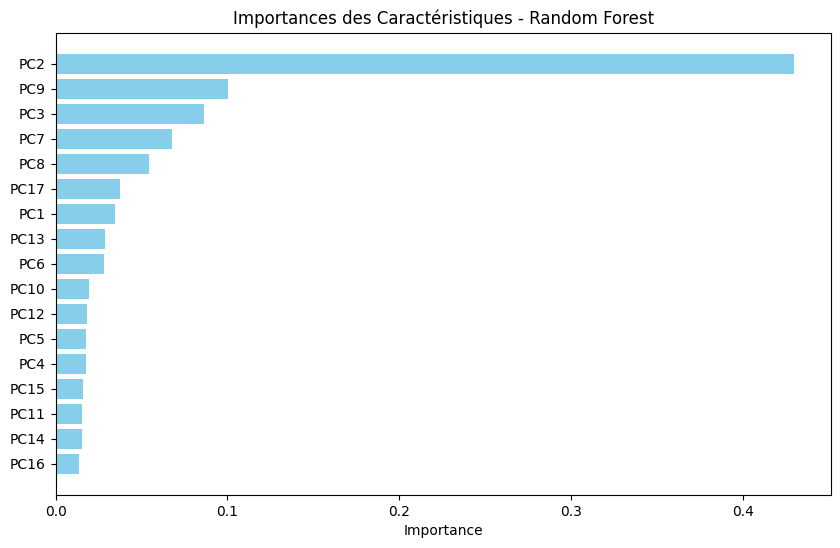

In [4]:
import matplotlib.pyplot as plt

# Importance des caractéristiques pour Random Forest
importances_rf = random_forest_model.feature_importances_

# Créer un DataFrame pour l'importance des caractéristiques
feature_importance_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importances_rf})

# Trier les caractéristiques par importance
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)

# Visualiser l'importance des caractéristiques
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], color='skyblue')
plt.title('Importances des Caractéristiques - Random Forest')
plt.xlabel('Importance')
plt.gca().invert_yaxis()  # Inverser pour avoir les plus importantes en haut
plt.show()


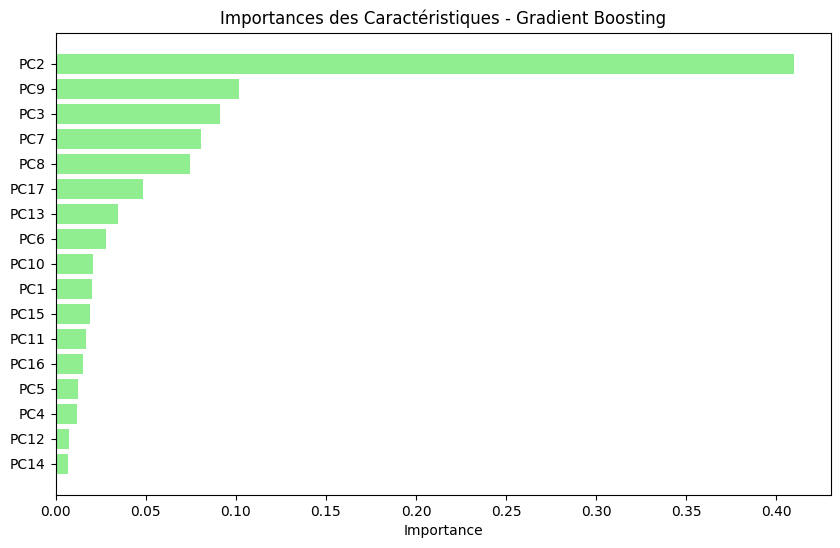

In [5]:
# Importance des caractéristiques pour Gradient Boosting
importances_gb = gradient_boosting_model.feature_importances_

# Créer un DataFrame pour l'importance des caractéristiques
feature_importance_gb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_gb})

# Trier les caractéristiques par importance
feature_importance_gb = feature_importance_gb.sort_values(by='Importance', ascending=False)

# Visualiser l'importance des caractéristiques
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_gb['Feature'], feature_importance_gb['Importance'], color='lightgreen')
plt.title('Importances des Caractéristiques - Gradient Boosting')
plt.xlabel('Importance')
plt.gca().invert_yaxis()  # Inverser pour avoir les plus importantes en haut
plt.show()


On s'interesse à PC2

In [6]:
pca_model = joblib.load('PCA model/pca_model.pkl')

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df = pd.read_csv('../../welddb/welddb_cleaned_for_pca.csv')
# drop all other target columns

df = df.drop(columns=['Ultimate tensile strength (MPa)', 'Elongation (%)',
       'Yield strength (MPa)', 'Charpy temperature (deg C)',
       'Charpy impact toughness (J)', 'Hardness (kgmm-2)', '50 % FATT',
       'Primary ferrite in microstructure (%)',
       'Ferrite with second phase (%)', 'Acicular ferrite (%)',
       'Martensite (%)', 'Ferrite with carbide aggregate (%)'])
# Filter the dataset to include only rows where target is not missing
df_red = df[df[target].notna()]


# Initialize the Iterative Imputer
iterative_imputer = IterativeImputer()

# Apply the iterative imputer on the dataset (excluding the target target)
df_features = df_red.drop(columns=[target])
df_imputed_iterative = pd.DataFrame(iterative_imputer.fit_transform(df_features), columns=df_features.columns)



In [9]:
# Retrieve the PCA components (loadings) for PC2
pc2_loadings = pd.DataFrame(pca_model.components_[1], index=df_imputed_iterative.columns, columns=['PC2 Loadings'])

# Sort the loadings by absolute value to see which variables contribute the most to PC2
pc2_loadings_sorted = pc2_loadings.abs().sort_values(by='PC2 Loadings', ascending=False)

# Display the top variables contributing to PC1
pc2_loadings_sorted.head(10)


,PC2 Loadings
Tin concentration (weight%),0.385229
Heat input (kJmm-1),0.325902
Antimony concentration (weight%),0.313735
Carbon concentration (weight%),0.287392
Arsenic concentration (weight%),0.280483
Nitrogen concentration (weight%),0.275158
Tungsten concentration (weight%),0.274751
Puissance (W),0.246480
Cobalt concentration (weight%),0.244656
Post weld heat treatment time (hours),0.189450


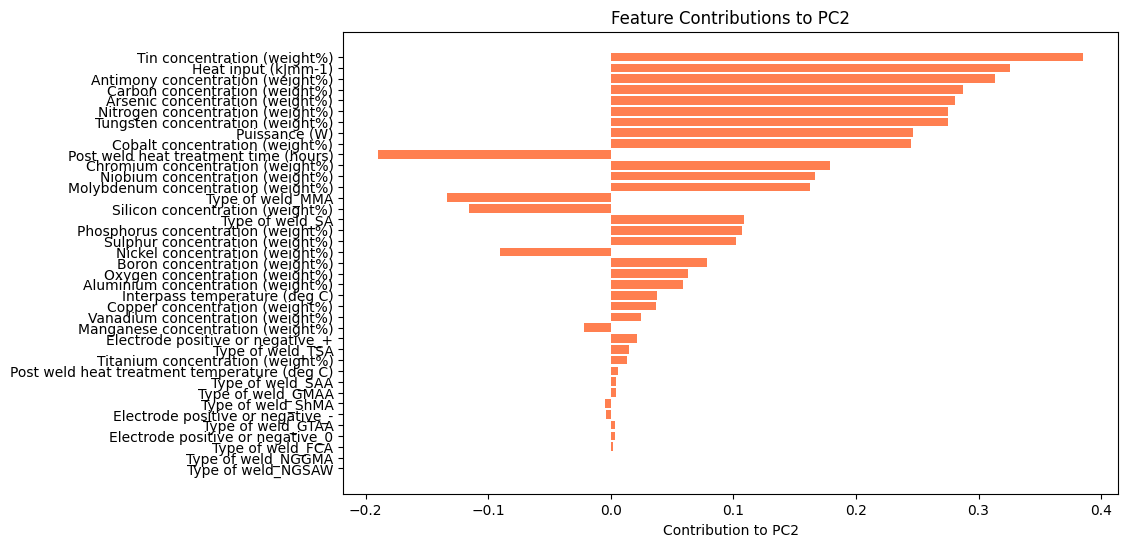

In [10]:
# Get the loadings for PC2 (10th component, index 9 in 0-based index)
pc10_loadings = pca_model.components_[1]

# Create a DataFrame for PC10 loadings
pc10_contributions = pd.DataFrame({'Feature': df_imputed_iterative.columns, 'Contribution to PC2': pc10_loadings})

# Sort by absolute contribution
pc10_contributions['Abs Contribution'] = pc10_contributions['Contribution to PC2'].abs()
pc10_contributions = pc10_contributions.sort_values(by='Abs Contribution', ascending=False)

# Plot a bar chart for PC10
plt.figure(figsize=(10, 6))
plt.barh(pc10_contributions['Feature'], pc10_contributions['Contribution to PC2'], color='coral')
plt.title('Feature Contributions to PC2')
plt.xlabel('Contribution to PC2')
plt.gca().invert_yaxis()  # Invert to show the largest contributors on top
plt.show()
